In [2]:
##Author: Kushin Mukherjee

I recommend running this notebook inside a conda environment to keep things organized and for reproducibility.

Download and install conda: https://docs.conda.io/projects/conda/en/latest/user-guide/install/  
Creating an environment: https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html

Some tips for installing packages:
First, activate your environment then install pip within the environment so that all the packages you install don't get installed to your global path. To do so:  
Type `conda install pip` in your terminal

Then, when in the project directory:  
Type `pip install -r requirements.txt`


We're using python 3 plus the latest versions of all the packages listed below. Be sure to update before running this nb

In [210]:
### import packages

import sys
import random
import scipy
from importlib import reload
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from IPython.display import clear_output
import svgpathtools
import os.path
from collections import Counter
import svg_rendering_helpers as srh



from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### Reading in raw sketch dataset and preparing our stimulus set for NEXT

In [4]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
code_dir = os.getcwd()
plot_dir = os.path.join(proj_dir,'plots')
data_dir = os.path.join(proj_dir,'data')


if not os.path.exists(code_dir):
    os.makedirs(code_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# if svg_rendering_helpers.py not in sys.path:
#     sys.path.append(os.path.join(proj_dir,svg_rendering_helpers.py)) 

In [15]:
D = pd.read_csv(os.path.join(data_dir,'semantic_parts_annotated_data.csv'))

In [16]:
def listify(string):
    split_list = string.split("'")
    l=[", u","[u","]"]
    out = [x for x in split_list if x not in l]
    return(out)
    

In [17]:
### Some string manipulation to get our svg strings in the right format
D.sketch_svg_string = D.sketch_svg_string.apply(listify)

### check
len(D.sketch_svg_string[0])

8

In [18]:
##Unique object categories in our dataset
unique_cats = np.unique(D.category)
unique_cats

array(['bird', 'car', 'chair', 'dog'], dtype=object)

In [19]:
#Creating a spline-level df where the modal label is set as the 'true' label for any given spline

spline_df= D.groupby('spline_id').agg(lambda x: Counter(x).most_common(1)[0][0])
spline_df.reset_index(level=0, inplace=True)

##Creating a stroke-level dataframe that takes the mode value of annotation for its children splines to set as its
##label value

from collections import Counter


from collections import OrderedDict
stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})


### Generating data for triplets task

No need to run cells until next heading unless pngs of the sample sketches are needed


In [365]:
## We need to exclude some "bad sketches", which are mostly just handwritten text instead of drawings

bad_sketches = [
'3058-fb4fe740-d862-453b-a08f-44375a040165_21',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_8',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_12',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_23',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_24',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_15',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_24',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_16',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_20',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_22',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_7',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_13',
'6311-cd21a68a-f1df-4290-b744-b0c7c7c60ed8_5',
'6786-9c3169eb-962e-468b-8922-b99247975eb2_32',
'0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_32',
'3113-105e6653-7fd1-4451-af00-46bb3145880a_6'
]

stroke_df = stroke_df[~stroke_df['sketch_id'].isin(bad_sketches)]

In [366]:
### Currently constrained by minimum number of sketches in a conditionXcategoryXexemplar cell, which is 2
### We have 2*4*8*2 (128) sketches in total

random.seed(1022)
run=True
if run==True:
    sample_sketches= []

    for this_cat in unique_cats:
        cat_df = stroke_df[stroke_df['category']== this_cat]
        unique_items = np.unique(cat_df['target'])
        for this_item in unique_items:
            item_df = cat_df[cat_df['target']==this_item]
            unique_conds = np.unique(item_df['condition'])
            for this_cond in unique_conds:
                cond_df = item_df[item_df['condition']==this_cond]
                us = np.unique(cond_df['sketch_id']) ## unique sketches in cell
                if len(us)<4:
                    print("not enough in cell", this_item, this_cond,len(us))
                    break
                rand_sl = np.random.choice(us,size = 2,replace=False) ## list of random sketch ids
                sample_sketches.append(rand_sl)


    sample_sketches = [y for x in sample_sketches for y in x] ##flatten list

    assert(len(np.unique(sample_sketches))==len(sample_sketches))


In [367]:
render_df = stroke_df[stroke_df['sketch_id'].isin(sample_sketches) ]

In [368]:
render_df.sketch_id.nunique()

128

In [369]:
###Clear directories
run==True
if run==True:
    svg_dir = os.path.join(plot_dir,'triplet_sketches')
    png_dir =  os.path.join(plot_dir,'triplet_sketches_png')
    for this_dir in [svg_dir,png_dir]:
        filelist = [ f for f in os.listdir(this_dir) ]
        for this_sketch in filelist:
            file_path = os.path.join(this_dir, this_sketch)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    os.unlink(file_path)
                #elif os.path.isdir(file_path): shutil.rmtree(file_path)
            except Exception as e:
                print(e)

[Errno 2] No such file or directory: '/Users/kushin/Documents/GitHub/UW_sketch_work/plots/triplet_sketches/2216-946e1652-c7ea-4dc7-8829-129c7cc55176_27.svg'
[Errno 2] No such file or directory: '/Users/kushin/Documents/GitHub/UW_sketch_work/plots/triplet_sketches/9840-46b175c7-8715-49fe-99a6-0dae8776ef1b_1.svg'
[Errno 2] No such file or directory: '/Users/kushin/Documents/GitHub/UW_sketch_work/plots/triplet_sketches/2216-946e1652-c7ea-4dc7-8829-129c7cc55176_32.svg'
[Errno 2] No such file or directory: '/Users/kushin/Documents/GitHub/UW_sketch_work/plots/triplet_sketches/7285-f99d9991-de84-43cc-b359-e9de387ab0b5_5.svg'
[Errno 2] No such file or directory: '/Users/kushin/Documents/GitHub/UW_sketch_work/plots/triplet_sketches/5650-cb4a9e85-a383-43f6-83e6-331e286811d1_29.svg'
[Errno 2] No such file or directory: '/Users/kushin/Documents/GitHub/UW_sketch_work/plots/triplet_sketches/2323-a9c585ff-0096-4f9c-8be4-e202993c654f_11.svg'
[Errno 2] No such file or directory: '/Users/kushin/Document

In [370]:
###Render out SVGs and PNGs

reload(srh)
really_run = True

if really_run==True:

    for sketch in render_df.sketch_id.unique():
        this_sketch = render_df.query('sketch_id == @sketch')
        svgs = list(this_sketch.svg)
        srh.render_svg(svgs,out_dir ="triplet_sketches", base_dir=plot_dir,out_fname='{}.svg'.format(sketch))
### Create path to svgs and convert to png for feature extraction
really_run = True

if really_run==True:
    svg_paths= srh.generate_svg_path_list(os.path.join(plot_dir,'triplet_sketches'))
    srh.svg_to_png(svg_paths,out_dir="triplet_sketches_png",base_dir=plot_dir)



convert /Users/kushin/Documents/GitHub/UW_sketch_work/plots/triplet_sketches/1752-fba5d4af-f103-4e3a-b100-d479bb0a2d11_19.svg /Users/kushin/Documents/GitHub/UW_sketch_work/plots/triplet_sketches_png/1752-fba5d4af-f103-4e3a-b100-d479bb0a2d11_19.png


In [743]:
render_df_meta = pd.DataFrame(render_df.groupby(['sketch_id','category','target','condition','label']).agg(num_strokes=pd.NamedAgg(column='stroke_id', aggfunc=lambda x: len(x.unique()))))
render_df_meta=render_df_meta.reset_index()
render_df_meta

,sketch_id,category,target,condition,label,num_strokes
0,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,chair,squat,further,armrest,1
1,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,chair,squat,further,backrest,8
2,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,chair,squat,further,leg,3
3,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,chair,squat,further,seat,2
4,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_15,bird,bluejay,further,body,1
...,...,...,...,...,...,...
522,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_21,car,brown,closer,windshield,2
523,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_30,dog,bullmastiff,closer,body,1
524,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_30,dog,bullmastiff,closer,ear,1
525,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_30,dog,bullmastiff,closer,eye,1


In [744]:
render_df_meta.to_csv(index=False,path_or_buf=os.path.join(data_dir,'render_meta_data.csv'))

### Create \*.yml file to create stims for triplets task

The sketches for the experimented are currently hosted on Kushin's personal webpage : https://github.com/kushinm/kushinm.github.io/tree/master/triplet_sketches_png

In [376]:
###create dictionary of HTML for .yml file
import yaml
filenames = [f for f in os.listdir(os.path.join(plot_dir, 'triplet_sketches_png') )\
             if os.path.isfile(os.path.join(os.path.join(plot_dir, 'triplet_sketches_png'), f))]

target_list=[]
for f in filenames:
    sketch_id = f.split('.')[0]
    target_list.append('<img alt="{}" src="https://raw.githubusercontent.com/kushinm/kushinm.github.io/master/triplet_sketches_png/{}" />'.format(sketch_id, f))
    


In [377]:
### Write dictionary to .yml
data = dict(
    targets = target_list
)
data['instructions']='<p>Choose the sketch from the bottom row that looks <i>most similar</i> to the sketch in the top row</p>'
    

with open(os.path.join(data_dir,'triplets_pilot.yml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

## Extract features for analysis

### Judy's VGG19 extractor

Features extracted through separate *.py script

In [745]:
feats = pd.DataFrame(np.load(os.path.join(data_dir,'features/FEATURES_FC6_sketch_no-channel-norm_triplets_128.npy')))

feats_meta = pd.read_csv(os.path.join(data_dir,'features/METADATA_sketch_triplets_128.csv'))

In [746]:
feats_df1 = pd.concat([feats_meta,feats], axis = 1)
render_df_meta = pd.read_csv(os.path.join(data_dir,'render_meta_data.csv'))

In [750]:
_meta_df1 = pd.DataFrame(render_df_meta.groupby(['sketch_id','condition','category','target']).agg(dummy=pd.NamedAgg(column='num_strokes', aggfunc='max')))
_meta_df1=_meta_df1.reset_index()

In [752]:
feats_df1
feats_df1 = feats_df1.join(_meta_df1.set_index('sketch_id'), on = 'sketch_id')
feats_df1=feats_df1.drop(columns=['dummy'])



In [455]:
feat_cols = np.arange(0,4095).tolist()

## PCA

In [466]:
pca = PCA(n_components=3)

In [467]:
pca_result = pca.fit_transform(feats_df1[feat_cols].values)


In [468]:
feats_df1['pca-one'] = pca_result[:,0]
feats_df1['pca-two'] = pca_result[:,1] 
feats_df1['pca-three'] = pca_result[:,2]

In [469]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.13681635 0.11975395 0.0723869 ]


Text(0.5, 1.0, 'PCA visualization')

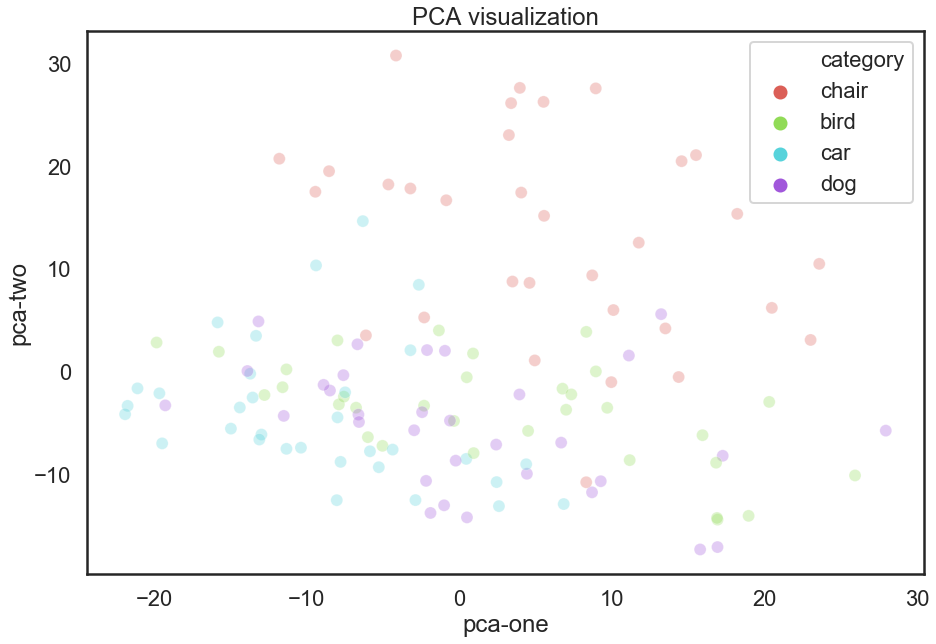

In [470]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="category",
    palette=sns.color_palette("hls", 4),
    data=feats_df1,
    legend="full",
    alpha=0.3
).set_title('PCA visualization')

In [464]:
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats_df1[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 128 samples in 0.001s...
[t-SNE] Computed neighbors for 128 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 128 / 128
[t-SNE] Mean sigma: 14.442572
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.251278
[t-SNE] KL divergence after 300 iterations: 0.793299
t-SNE done! Time elapsed: 0.3485550880432129 seconds


Text(0.5, 1.0, 't-SNE visualization')

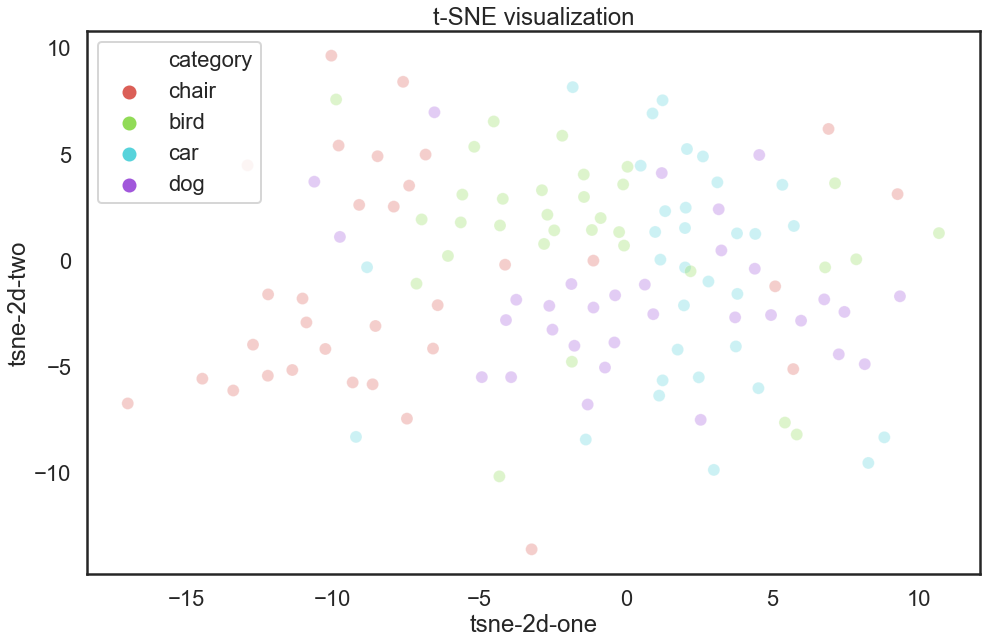

In [465]:
feats_df1['tsne-2d-one'] = tsne_results[:,0]
feats_df1['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category",
    palette=sns.color_palette("hls", 4),
    data=feats_df1,
    legend="full",
    alpha=0.3
    
).set_title('t-SNE visualization')

## SALMON data analysis

In [756]:
## Read the many json files that have our triplet judgement data data (clunky for now but best we have)

progress_1 = pd.read_json(os.path.join(proj_dir, 'response_saves/responses220.json'))
progress_2 = pd.read_json(os.path.join(proj_dir, 'response_saves/responses77.json'))
progress_3 = pd.read_json(os.path.join(proj_dir, 'response_saves/responses68.json'))

In [757]:
progress_1.time_received.nunique()

2463

In [758]:
progress_2.time_received.nunique()

358

In [759]:
progress_3.time_received.nunique()

804

In [760]:
progress_1.time_received.nunique()+progress_2.time_received.nunique()+progress_3.time_received.nunique()

3625

In [761]:
##Concatenate all our judgement data

progress_full = pd.concat([progress_1, progress_2,progress_3], axis=0)

In [762]:
progress_full.time_received.nunique()

3625

In [763]:
progress_full.head()
progress_full=progress_full.reset_index()

In [700]:
##Do some string manipulation so that each object is the sketch_id

In [764]:
progress_full.left_object = progress_full.left_object.apply(lambda x: x.split('"')[1])
progress_full.right_object = progress_full.right_object.apply(lambda x: x.split('"')[1])
progress_full.head_object = progress_full.head_object.apply(lambda x: x.split('"')[1])
progress_full.winner_object = progress_full.winner_object.apply(lambda x: x.split('"')[1])

In [766]:
progress_full

,index,head,left,right,winner,puid,time_received,left_object,right_object,head_object,winner_object,left_src,right_src,head_src,winner_src,time_received_since_start
0,0,113,105,103,103,2716393172,1.575402e+09,7285-f99d9991-de84-43cc-b359-e9de387ab0b5_31,3169-1a552a49-44e5-4a78-bed6-72a6aca82625_9,2721-f28245be-a3ac-425e-9538-5c0803980807_3,3169-1a552a49-44e5-4a78-bed6-72a6aca82625_9,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,12691.351969
1,1,97,32,29,32,2716393172,1.575402e+09,7988-85f09ac5-8225-48f3-9367-e890cdbb4ffb_3,7988-85f09ac5-8225-48f3-9367-e890cdbb4ffb_19,4609-852cfd4d-44d8-42fc-9c7c-8460ce918f16_18,7988-85f09ac5-8225-48f3-9367-e890cdbb4ffb_3,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,12693.957909
2,2,31,101,7,7,2716393172,1.575402e+09,3956-be947e80-531d-42ce-b238-e0b3bd997edf_8,1682-6ebee481-ec2e-4624-a5d2-2e74803e940d_8,1970-1377644d-0742-4343-ae91-737a5b0fbd1f_8,1682-6ebee481-ec2e-4624-a5d2-2e74803e940d_8,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,12697.453488
3,3,34,67,22,67,2716393172,1.575402e+09,2216-946e1652-c7ea-4dc7-8829-129c7cc55176_32,2611-14794729-06be-4093-aac5-8a631b1fa894_26,6486-e7055f99-5fec-4fb7-a7fd-7ebf49ba594f_31,2216-946e1652-c7ea-4dc7-8829-129c7cc55176_32,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,12699.013656
4,4,119,16,60,60,2716393172,1.575402e+09,1682-6ebee481-ec2e-4624-a5d2-2e74803e940d_20,2121-a3dd33f4-82fc-4913-991c-1d372f6923f0_17,6311-cd21a68a-f1df-4290-b744-b0c7c7c60ed8_21,2121-a3dd33f4-82fc-4913-991c-1d372f6923f0_17,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,12702.653413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,799,127,35,99,35,1955754682,1.575477e+09,3257-2f4b83dc-a618-4194-a666-67e8a3f5539d_15,2121-a3dd33f4-82fc-4913-991c-1d372f6923f0_21,2721-f28245be-a3ac-425e-9538-5c0803980807_5,3257-2f4b83dc-a618-4194-a666-67e8a3f5539d_15,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,2964.418308
3621,800,123,50,63,63,1955754682,1.575477e+09,3257-2f4b83dc-a618-4194-a666-67e8a3f5539d_8,3169-1a552a49-44e5-4a78-bed6-72a6aca82625_13,1682-6ebee481-ec2e-4624-a5d2-2e74803e940d_5,3169-1a552a49-44e5-4a78-bed6-72a6aca82625_13,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,2966.183925
3622,801,6,92,42,42,1955754682,1.575477e+09,8265-92081336-152b-4a90-bdb4-fea038f4c9b8_18,4609-852cfd4d-44d8-42fc-9c7c-8460ce918f16_14,5708-fd15d921-aa1b-46e4-ad51-e0c743c2db0d_25,4609-852cfd4d-44d8-42fc-9c7c-8460ce918f16_14,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubusercontent.com/kushinm/kush...,2967.896623
3623,802,98,94,115,115,1955754682,1.575477e+09,6224-40ab6004-b7c1-4d1d-a308-a061099290fc_1,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_5,2216-946e1652-c7ea-4dc7-8829-129c7cc55176_13,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_5,https://raw.githubusercontent.com/kushinm/kush...,https://raw.githubuserco

In [767]:
feats_df1 ## This is our CNN Data

,feature_ind,sketch_id,0,1,2,3,4,5,6,7,...,4089,4090,4091,4092,4093,4094,4095,condition,category,target
0,0,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,2.076044,0.886450,0.000000,0.0,0.0,0.000000,0.836140,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.927369,further,chair,squat
1,1,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_15,2.452158,2.412398,0.508882,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.074560,0.000000,0.0,0.000000,2.391883,further,bird,bluejay
2,2,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_18,2.603316,2.160689,0.000000,0.0,0.0,0.000000,0.959337,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.983835,further,chair,knob
3,3,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_29,1.819171,1.241084,0.000000,0.0,0.0,0.229416,0.930181,0.0,...,0.000000,0.0,0.574069,0.000000,0.0,0.000000,1.246116,closer,bird,tomtit
4,4,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_5,0.851439,0.915498,0.000000,0.0,0.0,0.891402,0.038671,0.0,...,0.164081,0.0,0.000000,0.000000,0.0,0.000000,0.779328,closer,bird,nightingale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,123,8297-39d66207-4fb6-430c-8e2b-4f95213b6a55_9,3.061178,0.737765,0.000000,0.0,0.0,0.000000,0.315829,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2.034183,further,chair,woven
124,124,8486-a0a44a5f-4eb9-4924-b2b6-247478e1ce8d_6,2.074374,0.000000,1.193633,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,1.301140,0.441937,0.0,0.000000,0.000000,further,chair,straight
125,125,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_14,1.402668,0.830638,0.000000,0.0,0.0,0.181231,1.101940,0.0,...,0.000000,0.0,0.050455,0.000000,0.0,0.000000,1.225736,further,dog,pug
126,126,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_21,1.140599,0.134968,0.000000,0.0,0.0,0.267462,0.000000,0.0,...,2.036638,0.0,0.563869,0.000000,0.0,0.000000,0.000000,closer,car,brown


In [18]:
### Save out to csvs to avoid having to do all this again

feats_df1.to_csv(os.path.join(data_dir, 'CNN_feats_plus_meta.csv'))
progress_full.to_csv(os.path.join(data_dir, 'triplet_judgements.csv'))

NameError: name 'feats_df1' is not defined

## How well can we predict judgements using CNN features?

In [786]:
mdist = np.corrcoef(feats_df1[feat_cols]) ### distance matrix of cnn feats using correlation

In [857]:
import scipy
mdist = scipy.spatial.distance.pdist(feats_df1[feat_cols], metric='euclidean')### distance matrix of cnn feats using euclidean dist
mdist = scipy.spatial.distance.squareform(mdist)

In [53]:
def score(fdf, ndf):
    mdist = scipy.spatial.distance.pdist(fdf[feat_cols], metric='euclidean')
    mdist = scipy.spatial.distance.squareform(mdist)
    o = np.zeros(ndf.shape[0])
    dist_df = pd.DataFrame(mdist, columns=fdf.sketch_id, index=fdf.sketch_id)
    
    mitems = dist_df.index
    nitems =ndf.shape[0]
    for i in range(nitems):
        ivec =  dist_df[dist_df.index==ndf['head_object'].iloc[i]]
        dleft = ivec[ndf['left_object'].iloc[i]].values
        dright = ivec[ndf['right_object'].iloc[i]].values
        if(dleft<dright):
            pred = ndf.left_object.iloc[i]
        else:
            pred = ndf.right_object.iloc[i]
        if(pred==ndf.winner_object.iloc[i]):
            o[i] = 1
    return(o)

In [859]:
results = score(mdist, progress_full)

In [860]:
np.mean(results) ## mean accuracy using cnn feats ~60% not bad :) 

0.5917241379310345

In [34]:
embed_labels = pd.read_csv(os.path.join(data_dir,'labels.txt'),header=None) ### read in next features

In [35]:
embed_coords = pd.read_csv(os.path.join(data_dir,'model.csv'), header=None)
embed_df= pd.concat([embed_labels,embed_coords],axis=1)
embed_df.columns = ['sketch_id','coord_1','coord_2']

embed_df['category']= embed_df['sketch_id'].apply(lambda x: feats_df1[feats_df1['sketch_id']==x].iloc[0].category)

embed_df['condition']= embed_df['sketch_id'].apply(lambda x: feats_df1[feats_df1['sketch_id']==x].iloc[0].condition)

embed_df['target']= embed_df['sketch_id'].apply(lambda x: feats_df1[feats_df1['sketch_id']==x].iloc[0].target)





NameError: name 'feats_df1' is not defined

Text(0.5, 1.0, 'triplets judgement embeddings visualization')

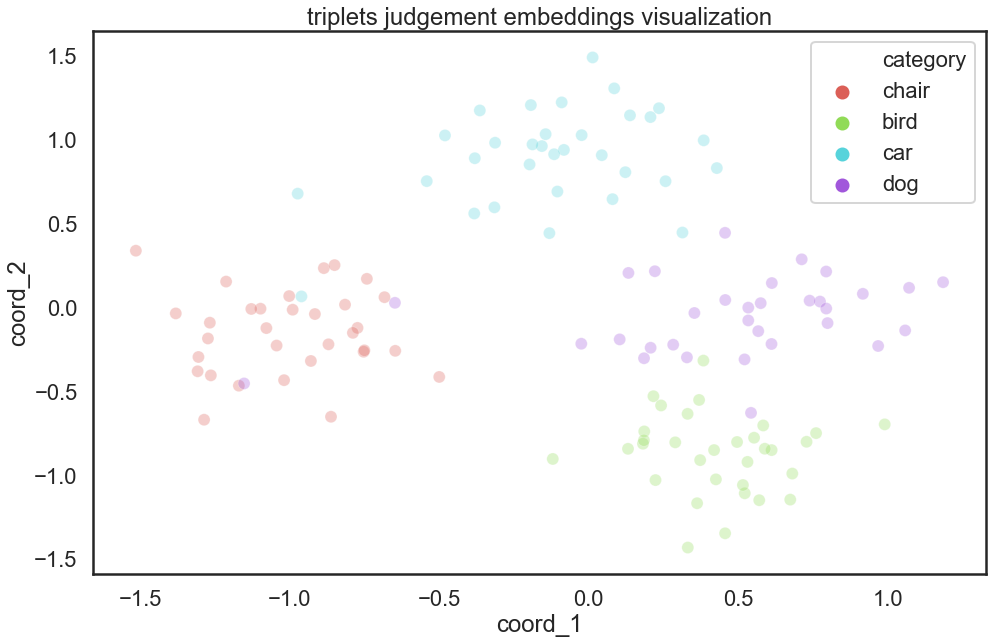

In [905]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="coord_1", y="coord_2",
    hue="category",
    palette=sns.color_palette("hls", 4),
    data=embed_df,
    legend="full",
    alpha=0.3
).set_title('triplets judgement embeddings visualization')

## SPRING 2020 Analyses

In [20]:
cnn_feats = pd.read_csv(os.path.join(data_dir,'CNN_feats_plus_meta.csv')) ## read in cnn feats of 128 sketches

In [164]:
cnn_feats
feat_cols = np.arange(0,4096).astype(object).tolist()


In [23]:
next_df = pd.read_csv(os.path.join(data_dir,'triplet_judgements.csv'))  ## read in next judgement data

In [ ]:
D = pd.read_csv(os.path.join(data_dir,'semantic_parts_annotated_data.csv'))

In [24]:
### Create a dataframe of strokes and compute the length of those strokes. Each row is a unique stroke from the
### set of 128 sketches we used for NEXT

from svgpathtools import parse_path

unique_cats = D.category.unique()


from collections import Counter
from collections import OrderedDict

stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})

##Adding total arclength information to stroke dataframe

def calculate_arclength(svg):
    try:
        arclength= parse_path(svg).length()
    except ZeroDivisionError:
        print ('zero div error')
        arclength = 0
    return arclength
stroke_df['arc_length'] = stroke_df['svg'].apply(calculate_arclength)

In [243]:
stroke_df

,stroke_id,svg,sketch_id,label,stroke_num,condition,target,category,outcome,arc_length
0,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_0,"M46,96c8.69973,0 17.35061,-8.52875 26,-11c30.0...",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,backrest,0,further,squat,chair,True,277.595836
1,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_1,"M38,149c8.99426,5.81982 62.62859,51 42,51",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,seat,1,further,squat,chair,True,74.090413
2,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_2,"M44,151c1.47544,0 3.44082,-10.06449 10,-14c19....",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,seat,2,further,squat,chair,True,267.722792
3,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_3,"M83,183c34.38989,11.4633 5.00623,84 15,84",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,leg,3,further,squat,chair,True,92.259609
4,0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11_4,"M166,176c6.32553,0 12.87556,19.31334 16,24c13....",0647-bfcd78e5-085c-4631-a47c-0f3dadf71345_11,leg,4,further,squat,chair,True,103.108744
...,...,...,...,...,...,...,...,...,...,...
7692,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6_3,"M86,185c-12.03351,0 -11.41975,29.55967 -17,37",9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6,leg,3,further,bluejay,bird,True,42.789216
7693,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6_4,"M70,222c-3.04829,0 -13,7.33711 -13,10",9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6,feet,4,further,bluejay,bird,True,16.912969
7694,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6_5,"M72,223c8.52958,0 13.97992,8.97992 19,14",9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6,feet,5,further,bluejay,bird,True,24.352426
7695,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6_6,"M113,213c-4.67448,0 -14,11.8928 -14,16",9877-e1c91119-da46-40fa-82fe-17405ca56a3b_6,feet,6,further,bluejay,bird,True,22.153626


In [ ]:
### Create part-based semantic vectors using this stroke dataframe

In [25]:
unique_cats= np.unique(D['category'])
##Create empty dictionary with categories as keys. We will use this to store part occurrence data for our categories
label_vect_dict = {unique_cats[0]:None,unique_cats[1]:None,unique_cats[2]:None,unique_cats[3]:None}


##Create vectors that contain the number of part instances in each sketch
num_annots=3

for category in unique_cats:
    DS= D[D['category']==category]
    unique_sketches_in_cat = np.unique(DS['sketch_id'])
    unique_labels_in_cat = np.unique(DS['label'])
    ## initialize matrix that has the correct dimensions
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)), dtype=int)
    unique_labels_in_cat= np.array(unique_labels_in_cat)
    for s,this_sketch in enumerate(unique_sketches_in_cat):
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSS = DS[DS['sketch_id']==this_sketch]
        annotation_ids = np.unique(DSS['annotation_id'].values)    
        for this_annotation in annotation_ids:
            DSA = DSS[DSS['annotation_id']==this_annotation]
            label_list = DSA.label.values
            for this_label in label_list:
                label_ind = unique_labels_in_cat==this_label
                label_vec[label_ind] += 1
            
        Label_Vec[s,:]=label_vec/num_annots
    label_vect_dict[category]= Label_Vec

valid_labels=[]
valid_labels_dict={}
for category in unique_cats:
    vect = label_vect_dict[category]
    thresh = 50
    #print 'These are the labels that appear at least {} times:'.format(thresh)
    #print unique_labels[np.sum(Label_Vec,0)>thresh]
    unique_labels_in_cat = np.unique(D[D['category']==category]['label'])
    plot_labels= unique_labels_in_cat[np.sum(vect,0)>thresh]
    valid_labels_dict[category]=plot_labels
    valid_labels.append(plot_labels)


    prop_labels=[]
    for part in plot_labels:
        DS=D[D['category']==category]
        prop_labels.append(DS[DS['label']==part]['annotation_id'].nunique()/DS['annotation_id'].nunique())
    
    
#     sns.set_context('talk')
#     plt.figure(figsize=(12,7))
#     plt.ylim(0,1)
#     h = plt.bar(plot_labels,prop_labels)
#     plt.title('Proportion of {} annotations with labels'.format(category))
#     plt.ylabel('proportion of annotations')
#     plt.xlabel('Part')
    
##flattening valid labels
valid_labels = [item for sublist in valid_labels for item in sublist]

In [26]:
###This is where we make a num unique labels * 2 X number of sketches vector 

feature_vec = np.zeros((len(stroke_df.sketch_id.unique()),len(valid_labels)*2), dtype=int)
ind=0
start_pos=0
end_pos=0
meta_list=[]
cols = ['sketch_id','target','condition','category','outcome']

for cat in unique_cats:
  
    DS= stroke_df[stroke_df['category']==cat]
    unique_labels_in_cat=valid_labels_dict[cat]
    unique_sketches_in_cat=DS['sketch_id'].unique()
    start_pos = end_pos
    end_pos+= len(unique_labels_in_cat)
    print (start_pos, end_pos)
    clear_output(wait=True)
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)*2), dtype=int)
    arc_length_vec = np.zeros((len(unique_sketches_in_cat),len(valid_labels_dict[cat])), dtype=int)
    for s,sketch in enumerate(unique_sketches_in_cat):
        
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        arc_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSA=DS[DS['sketch_id']==sketch]
      
        meta_list.append(pd.Series([DSA['sketch_id'].unique(),DSA['target'].unique(),DSA['condition'].unique(),DSA['category'].unique(),DSA['outcome'].unique()], index=cols))
        label_list = DSA.label.values        
        for label in label_list:
            if label in unique_labels_in_cat:
                label_ind = unique_labels_in_cat==label
                label_vec[label_ind] += 1
        for label in unique_labels_in_cat:
            DSB=DSA[DSA['label']==label]
            label_ind = unique_labels_in_cat==label
            arc_vec[label_ind] = DSB['arc_length'].sum()
            
        
        feature_vec[ind,start_pos:end_pos]=label_vec
        feature_vec[ind,start_pos+len(valid_labels):end_pos+len(valid_labels)]=arc_vec
        ind+=1
meta_df = pd.DataFrame(meta_list, columns=cols)

    


24 34


In [27]:
##Changing column values from np arrays to strings/boolean

def arr_to_str(arr):
    return (arr[0])
meta_df['sketch_id']=meta_df['sketch_id'].apply(arr_to_str)
meta_df['target']=meta_df['target'].apply(arr_to_str)
meta_df['condition']=meta_df['condition'].apply(arr_to_str)
meta_df['category']=meta_df['category'].apply(arr_to_str)
meta_df['outcome']=meta_df['outcome'].apply(arr_to_str)
    



In [28]:
feature_df= pd.DataFrame(feature_vec, columns=[s + '_numstrokes' for s in valid_labels]+[s + '_total_arclength' for s in valid_labels])


##Creating a compressed version of the feature df with no duplicates for parts. E.g. - no difference between
## dog leg and chair leg

labs_numstrokes=[]
labs_total_arclength=[]
for lab in np.unique(valid_labels):
    labs_numstrokes.append(lab +'_numstrokes')
    labs_total_arclength.append(lab+'_total_arclength')
feature_df_labs=labs_numstrokes+labs_total_arclength   
feature_df_final= pd.DataFrame(columns=feature_df_labs)


for this_lab in feature_df_labs:
    duplicates=[col for col in feature_df if col.startswith(this_lab)]
    feature_df_final[this_lab]= feature_df[duplicates].sum(axis=1)
feature_df = feature_df_final

In [29]:
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X
feature_df = normalize(feature_df)

In [30]:
part_feats = pd.concat((meta_df,feature_df),axis=1) ## dataframe for semantic features

In [31]:
part_feat_cols= feature_df.columns

In [32]:
part_feats_sub = part_feats[part_feats.sketch_id.isin(cnn_feats.sketch_id)]

In [174]:
cnn_feat_cols = np.arange(0,4096).astype(str).tolist()

In [168]:
## Read in NEXT embeddings and add necessary metadata for subsetting purposes

next_feats = pd.read_csv(os.path.join(data_dir,'model.csv'), header=None)
next_feats= pd.concat([embed_labels,embed_coords],axis=1)
next_feats.columns = ['sketch_id','coord_1','coord_2']
next_feat_cols = ['coord_1','coord_2']

next_feats['category']= next_feats['sketch_id'].apply(lambda x: cnn_feats[cnn_feats['sketch_id']==x].iloc[0].category)

next_feats['condition']= next_feats['sketch_id'].apply(lambda x: cnn_feats[cnn_feats['sketch_id']==x].iloc[0].condition)

next_feats['target']= next_feats['sketch_id'].apply(lambda x: cnn_feats[cnn_feats['sketch_id']==x].iloc[0].target)





In [199]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
### Concantenate all feats into a single df for now. Very hacky, find a better way to do this soon.

In [237]:
all_feats = pd.merge(pd.merge(next_feats,cnn_feats,on='sketch_id'),part_feats_sub.reset_index(),on='sketch_id')

In [8]:
train,test = train_test_split( all_feats, test_size=0.3,\
                                                    stratify= all_feats[['target_x','category_x']])


NameError: name 'train_test_split' is not defined

In [341]:
next_dist_t = scipy.spatial.distance.pdist(train[next_feat_cols], metric='euclidean')
next_dist_t = scipy.spatial.distance.squareform(next_dist_t)

cnn_dist_t = scipy.spatial.distance.pdist(train[cnn_feat_cols], metric='euclidean')
cnn_dist_t = scipy.spatial.distance.squareform(cnn_dist_t)

part_dist_t = scipy.spatial.distance.pdist(train[part_feat_cols], metric='euclidean')
part_dist_t =  scipy.spatial.distance.squareform(part_dist_t)

In [320]:
tri_inds = np.tril_indices(next_dist_t.shape[0])

next_dist_t = next_dist_t[tri_inds]
cnn_dist_t = cnn_dist_t[tri_inds]
part_dist_t = part_dist_t[tri_inds]

In [321]:
next_dist_v = scipy.spatial.distance.pdist(test[next_feat_cols], metric='euclidean')
next_dist_v = scipy.spatial.distance.squareform(next_dist_v)

cnn_dist_v = scipy.spatial.distance.pdist(test[cnn_feat_cols], metric='euclidean')
cnn_dist_v = scipy.spatial.distance.squareform(cnn_dist_v)

part_dist_v = scipy.spatial.distance.pdist(test[part_feat_cols], metric='euclidean')
part_dist_v =  scipy.spatial.distance.squareform(part_dist_v)

In [322]:
tri_inds = np.tril_indices(next_dist_v.shape[0])

next_dist_v = next_dist_v[tri_inds]
cnn_dist_v = cnn_dist_v[tri_inds]
part_dist_v = part_dist_v[tri_inds]

In [323]:
X = tuple(zip(cnn_dist_t, part_dist_t))
y = next_dist_t

In [324]:
model = LinearRegression().fit(X, y)

In [325]:
model.coef_

array([0.02235258, 0.01680201])

In [326]:
model.intercept_

0.11046905413107

In [327]:
X_v = tuple(zip(cnn_dist_v, part_dist_v))

In [328]:
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [329]:
pred = model.predict(X_v)

In [330]:
mean_squared_error(next_dist_v, pred)

0.3115173472294644

In [331]:
r2_score(next_dist_v, pred)

0.215510298166531

In [332]:
explained_variance_score(next_dist_v, pred)

0.21563362467054326

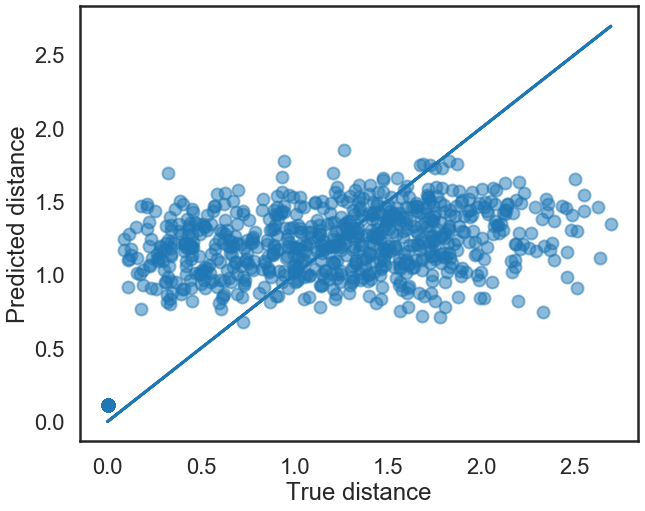

In [333]:
fig= plt.figure(figsize=(10,8))
#plot_cols=[col_dict[x] for x in fruit_names]
plt.scatter(next_dist_v, pred, alpha=0.5)
plt.plot(next_dist_v,next_dist_v)
plt.xlabel('True distance')
plt.ylabel('Predicted distance')
plt.show()

In [334]:
naive_y = np.full(len(next_dist_v), np.mean(y))

In [335]:
mean_squared_error(next_dist_v, naive_y)

0.3974931442310296

In [336]:
r2_score(next_dist_v, naive_y)

-0.0010013277653984076

In [337]:
explained_variance_score(next_dist_v, naive_y)

0.0

,sketch_id,coord_1,coord_2,category,condition,target
1,0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_15,0.185680,-0.739970,bird,further,bluejay
46,2721-f28245be-a3ac-425e-9538-5c0803980807_23,0.331214,-1.432832,bird,closer,bluejay
86,5708-fd15d921-aa1b-46e4-ad51-e0c743c2db0d_20,0.521641,-1.109129,bird,further,bluejay
105,7106-d5bbcf75-2894-4656-b1bd-19e73abf8a17_23,0.495908,-0.803105,bird,closer,bluejay
6,1593-3cebc49a-ef16-451d-a5a9-aad9b5ac4695_23,0.131325,-0.843724,bird,closer,crow
...,...,...,...,...,...,...
125,9877-e1c91119-da46-40fa-82fe-17405ca56a3b_14,0.738470,0.040265,dog,further,pug
9,1682-6ebee481-ec2e-4624-a5d2-2e74803e940d_12,0.773233,0.034769,dog,closer,weimaraner
39,2323-a9c585ff-0096-4f9c-8be4-e202993c654f_11,0.793978,-0.006852,dog,further,weimaraner
62,3485-477008c1-e529-4ad0-a62b-df33c782a5e3_27,0.574953,0.025233,dog,further,weimaraner


In [41]:
### Create a function to subset our dataframes by conditions as we need 

def subset_dataframe_by_condition(F,to_inspect='all',this_category='bird',this_object='bluejay'):
    '''
    input: F: dataframe (num_sketches x num_features)
           to_inspect: a string indicating whether to subset by ['object','category','all']
           this_category: IF to_inspect == 'category', then we define this to subset by that category only
           this_object: IF to_inspect == 'object', then we define this to subset by that object only
           
    returns: two feature matrices, c and f, corresponding to the close and far subsetted feature matrices
           
    '''
        
    F = F.sort_values(by=['category','target'])

    ## get context condition inds for subsetting dataframe
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'

    ## if we want to inspect particular category
    category_inds = F['category']==this_category

    ## if we want to inspect particular object
    obj_list = np.unique(F.target.values)
    obj_inds = F['target']==this_object  
    
    ## get names of columns that contain stroke-count & arclength information
    numstrokes_cols = [i for i in F.columns if i.split('_')[-1]=='numstrokes']
    arclength_cols = [i for i in F.columns if i.split('_')[-1]=='arclength']
    feat_cols = numstrokes_cols + arclength_cols
    
    if to_inspect == 'object':    
        ## extract particular row corresponding to this OBJECT in each condition
        f = F[(far_inds) & obj_inds][feat_cols].reset_index(drop=True)
        c = F[(close_inds) & obj_inds][feat_cols].reset_index(drop=True)
        obj_listf = F[(far_inds) & obj_inds]['target'].values
        obj_listc = F[(close_inds) & obj_inds]['target'].values
    elif to_inspect == 'category':
        ## extract particular rows corresponding to this CATEGORY in each condition
        f = F[(category_inds) & (far_inds)][feat_cols].reset_index(drop=True)
        c = F[(category_inds) & (close_inds)][feat_cols].reset_index(drop=True)
        obj_listf = F[(category_inds) & (far_inds)]['target'].values
        obj_listc = F[(category_inds) & (close_inds)]['target'].values
    elif to_inspect == 'all':
        ## extract particular rows corresponding to each condition
        f = F[far_inds][feat_cols].reset_index(drop=True)
        c = F[close_inds][feat_cols].reset_index(drop=True) 
        obj_listf = F[far_inds]['target'].values
        obj_listc = F[close_inds]['target'].values
        
    return c, f, obj_listc, obj_listf

In [46]:
 c1, f1, obj_listc1, obj_listf1 = subset_dataframe_by_condition(part_feats,to_inspect='all')

In [157]:
#### Generate ordered list of objects

cats = ['bird','dog','car','chair']
obj_list = []
cat_to_obj = {}
for this_cat in cats:
    fs = next_feats[next_feats.category == this_cat]
    obj_list.append(list(np.unique(fs.target.values)))
    cat_to_obj[this_cat] = list(np.unique(fs.target.values))
    

In [158]:
obj_list = [y for x in obj_list for y in x]

In [177]:
next_ob_means = []
for this_cat in cats:
    obs = cat_to_obj[this_cat]
    for this_ob in obs:
        
        next_ob_means.append(np.array(next_feats[next_feats.target==this_ob][next_feat_cols].mean()))
        
next_ob_means = np.stack(next_ob_means)

In [178]:
cnn_ob_means = []
for this_cat in cats:
    obs = cat_to_obj[this_cat]
    for this_ob in obs:
        
        cnn_ob_means.append(np.array(cnn_feats[cnn_feats.target==this_ob][cnn_feat_cols].mean()))
        
cnn_ob_means = np.stack(cnn_ob_means)

In [179]:
part_ob_means = []
for this_cat in cats:
    obs = cat_to_obj[this_cat]
    for this_ob in obs:
        
        part_ob_means.append(np.array(part_feats_sub[part_feats_sub.target==this_ob][part_feat_cols].mean()))
        
part_ob_means = np.stack(part_ob_means)

In [180]:
ob_means_all = np.concatenate((next_ob_means, cnn_ob_means,part_ob_means), axis=1)

In [183]:
ob_cols = [y for x in [next_feat_cols,cnn_feat_cols, part_feat_cols] for y in x]
all_ob_means = pd.DataFrame(ob_means_all,
                     columns = ob_cols)

In [194]:
## helper dictionaries 
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}
CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

In [197]:
all_ob_means['target'] = pd.Series(obj_list)
all_ob_means['category']= all_ob_means['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])


In [198]:
all_ob_means

,coord_1,coord_2,0,1,2,3,4,5,6,7,...,seat_total_arclength,tail_total_arclength,trunk_total_arclength,unknown_total_arclength,wheel_total_arclength,window_total_arclength,windshield_total_arclength,wing_total_arclength,target,category
0,0.383611,-1.021259,2.328486,1.929716,0.859685,0.000000,0.0,0.148832,0.000000,0.0,...,-0.512509,0.508609,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,2.005052,bluejay,bird
1,0.421833,-0.756670,1.834127,0.637649,0.587317,0.079291,0.0,0.000000,0.000000,0.0,...,-0.512509,-0.163198,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,0.095607,crow,bird
2,0.454644,-0.812946,2.083837,1.832875,0.734288,0.000000,0.0,0.275488,0.276158,0.0,...,-0.512509,0.332319,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,0.976468,cuckoo,bird
3,0.425522,-0.725400,1.037072,1.104969,0.164527,0.196321,0.0,0.278260,0.114358,0.0,...,-0.512509,-0.358546,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,0.366430,nightingale,bird
4,0.534077,-0.946935,2.024990,1.603984,0.083807,0.219701,0.0,0.043714,0.000000,0.0,...,-0.512509,0.410935,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,2.098062,pigeon,bird
5,0.372801,-0.737411,1.417281,1.237090,0.648002,0.266121,0.0,0.159611,0.123089,0.0,...,-0.512509,0.227498,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,0.287098,robin,bird
6,0.268650,-1.085510,1.457700,1.110163,0.115169,0.036384,0.0,0.303412,0.153060,0.0,...,-0.512509,0.053591,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,-0.104092,sparrow,bird
7,0.585156,-0.887657,1.538424,0.789497,0.513482,0.171753,0.0,0.139569,0.232545,0.0,...,-0.512509,-0.358546,-0.126676,-0.166428,-0.473193,-0.311413,-0.258760,1.909306,tomtit,bird
8,0.371368,0.158454,2.290697,0.391086,0.023343,0.549620,0.0,0.872286,0.374023,0.0,...,-0.512509,0.182235,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,-0.246343,basset,dog
9,0.662389,-0.055434,1.965069,1.514729,0.077606,0.138554,0.0,0.000000,0.670866,0.0,...,-0.512509,-0.170345,-0.126676,-0.199531,-0.473193,-0.311413,-0.258760,-0.246343,bloodhound,dog


In [222]:
train_means,test_means = train_test_split( all_ob_means, test_size=0.3,\
                                                    stratify= all_ob_means['category'])


In [223]:
next_dist_t = scipy.spatial.distance.pdist(train_means[next_feat_cols], metric='euclidean')
next_dist_t = scipy.spatial.distance.squareform(next_dist_t)

cnn_dist_t = scipy.spatial.distance.pdist(train_means[cnn_feat_cols], metric='euclidean')
cnn_dist_t = scipy.spatial.distance.squareform(cnn_dist_t)

part_dist_t = scipy.spatial.distance.pdist(train_means[part_feat_cols], metric='euclidean')
part_dist_t =  scipy.spatial.distance.squareform(part_dist_t)

In [224]:
tri_inds = np.tril_indices(next_dist_t.shape[0])

next_dist_t = next_dist_t[tri_inds]
cnn_dist_t = cnn_dist_t[tri_inds]
part_dist_t = part_dist_t[tri_inds]

In [225]:
next_dist_v = scipy.spatial.distance.pdist(test_means[next_feat_cols], metric='euclidean')
next_dist_v = scipy.spatial.distance.squareform(next_dist_v)

cnn_dist_v = scipy.spatial.distance.pdist(test_means[cnn_feat_cols], metric='euclidean')
cnn_dist_v = scipy.spatial.distance.squareform(cnn_dist_v)

part_dist_v = scipy.spatial.distance.pdist(test_means[part_feat_cols], metric='euclidean')
part_dist_v =  scipy.spatial.distance.squareform(part_dist_v)

In [226]:
tri_inds = np.tril_indices(next_dist_v.shape[0])

next_dist_v = next_dist_v[tri_inds]
cnn_dist_v = cnn_dist_v[tri_inds]
part_dist_v = part_dist_v[tri_inds]

In [227]:
X = tuple(zip(cnn_dist_t, part_dist_t))
y = next_dist_t
model = LinearRegression().fit(X, y)

In [228]:
print(model.coef_, model.intercept_)

[0.02880255 0.0911936 ] -0.222239165333443


In [229]:
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score
X_v = tuple(zip(cnn_dist_v, part_dist_v))

pred = model.predict(X_v)
mean_squared_error(next_dist_v, pred)


0.13748785328508462

In [230]:
print(r2_score(next_dist_v, pred),mean_squared_error(next_dist_v, pred))

0.6235681951705785 0.13748785328508462


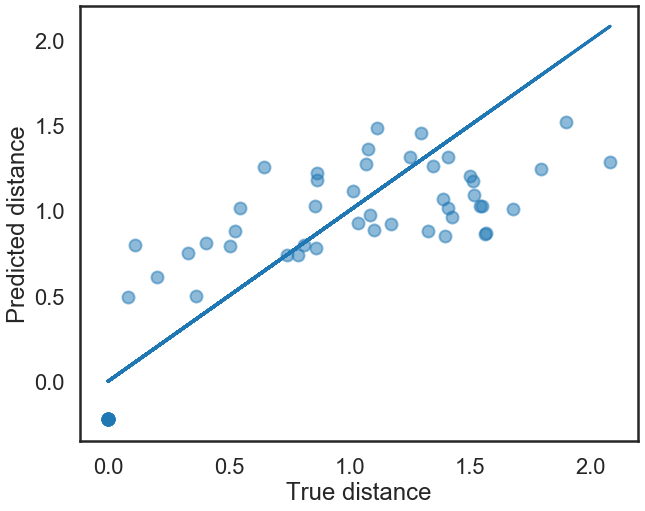

In [231]:
fig= plt.figure(figsize=(10,8))
#plot_cols=[col_dict[x] for x in fruit_names]
plt.scatter(next_dist_v, pred, alpha=0.5)
plt.plot(next_dist_v,next_dist_v)
plt.xlabel('True distance')
plt.ylabel('Predicted distance')
plt.show()